# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import datetime as dt
from itertools import product
from scipy.stats import normaltest
import os

sns.set_style('darkgrid')
np.random.seed(1205)

### Getting data

In [128]:

tickers = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'KO', 'PEP', 'PG', 'D']
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download adjusted closing prices
def download_price_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    full_data = data.dropna(axis=1)  # Drop tickers with missing data
    return full_data

prices = download_price_data(tickers, start_date, end_date)

def compute_log_returns(price_df):
    return np.log(price_df / price_df.shift(1)).dropna()

log_returns = compute_log_returns(prices)


[*********************100%***********************]  10 of 10 completed


In [129]:
#Utility functions

def shapiro_test(series):
    stat, p = stats.shapiro(series)
    conclusion = "Not Normal" if p < 0.05 else "Possibly Normal"
    return p, conclusion

def rolling_shapiro_test(returns_df, window_size=252):
    results = {}
    for ticker in returns_df.columns:
        series = returns_df[ticker].dropna()
        ticker_results = []
        for start in range(0, len(series) - window_size + 1, window_size):
            window = series.iloc[start:start+window_size]
            if len(window) < 3:
                continue
            stat, p = stats.shapiro(window)
            ticker_results.append((window.index[0], window.index[-1], p))
        results[ticker] = ticker_results
    return results

def remove_extremes(series, z_thresh=2): #taking Z-score of 2
    z_scores = (series - series.mean()) / series.std()
    return series[np.abs(z_scores) < z_thresh]


### Objective 1:
To test if there are periods of time when the log-returns of a stock/index have evidence of normal distribution.

In [130]:
# Run rolling normality test
rolling_results = rolling_shapiro_test(log_returns, window_size=252)
# Print which windows had p > 0.05 for each stock
for ticker, windows in rolling_results.items():
    print(f"\n{ticker} — Rolling Windows with p > 0.05 (suggesting normality):")
    for start, end, p in windows:
        if p > 0.05:
            print(f"  {start.date()} to {end.date()} → p = {p:.4f}")



AAPL — Rolling Windows with p > 0.05 (suggesting normality):
  2021-01-06 to 2022-01-04 → p = 0.1510
  2022-01-05 to 2023-01-05 → p = 0.0596

D — Rolling Windows with p > 0.05 (suggesting normality):
  2021-01-06 to 2022-01-04 → p = 0.0711

JNJ — Rolling Windows with p > 0.05 (suggesting normality):

JPM — Rolling Windows with p > 0.05 (suggesting normality):
  2021-01-06 to 2022-01-04 → p = 0.7677
  2022-01-05 to 2023-01-05 → p = 0.1432

KO — Rolling Windows with p > 0.05 (suggesting normality):
  2015-01-05 to 2016-01-04 → p = 0.2293

NVDA — Rolling Windows with p > 0.05 (suggesting normality):
  2022-01-05 to 2023-01-05 → p = 0.7070

PEP — Rolling Windows with p > 0.05 (suggesting normality):
  2017-01-04 to 2018-01-03 → p = 0.1449

PG — Rolling Windows with p > 0.05 (suggesting normality):

TSLA — Rolling Windows with p > 0.05 (suggesting normality):

WMT — Rolling Windows with p > 0.05 (suggesting normality):


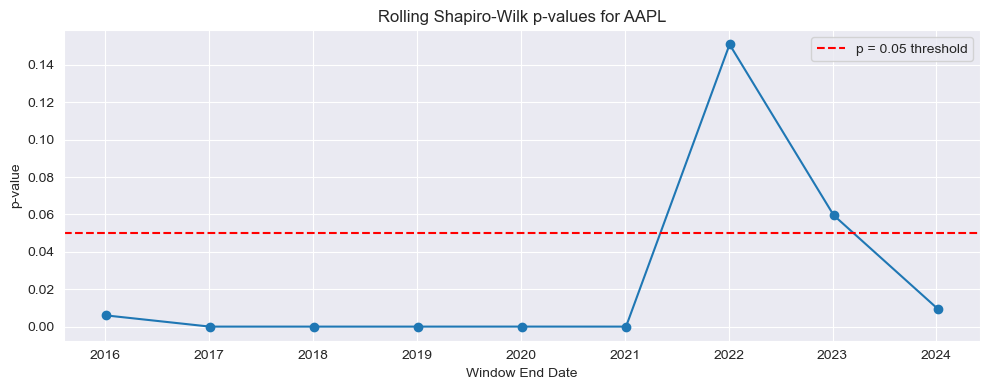

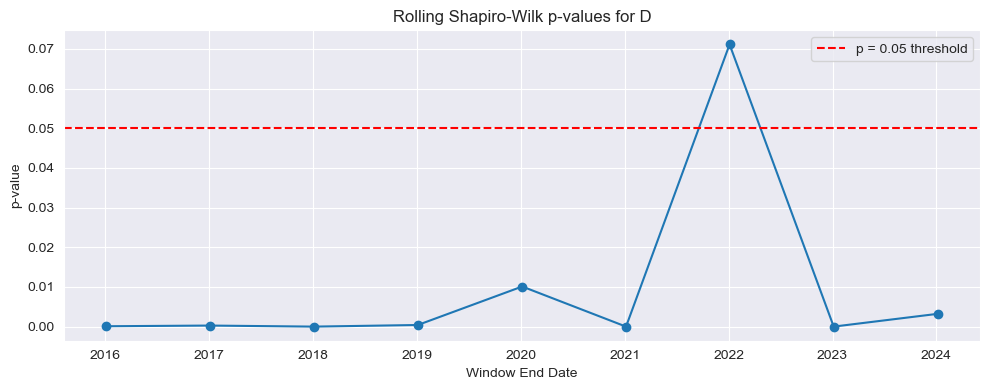

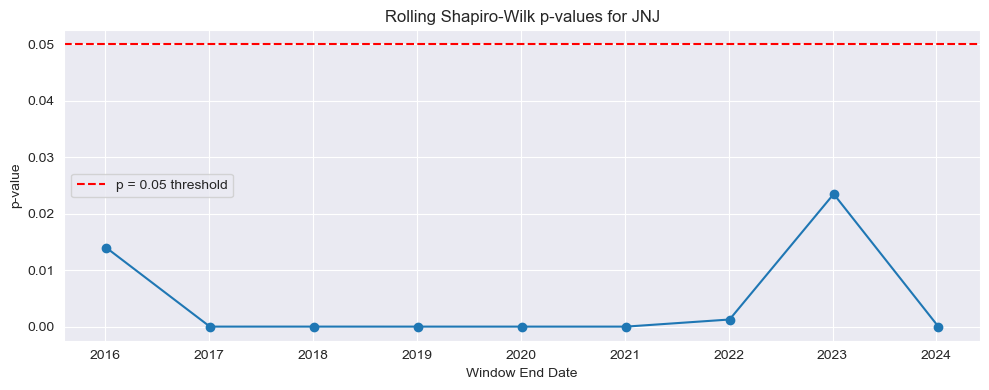

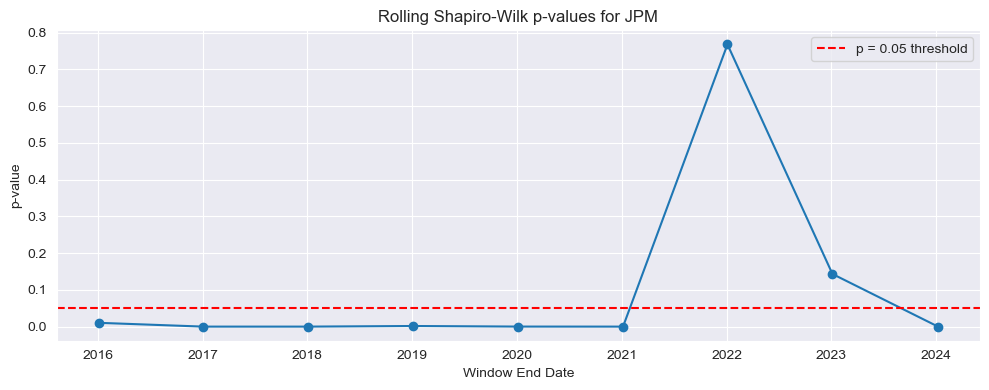

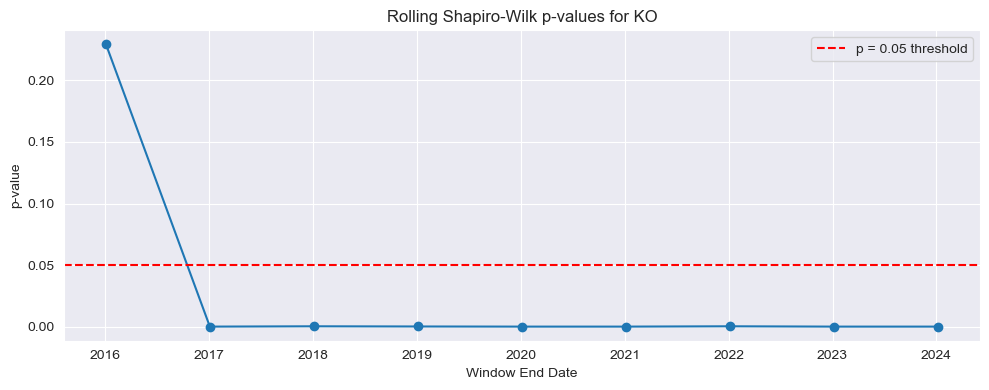

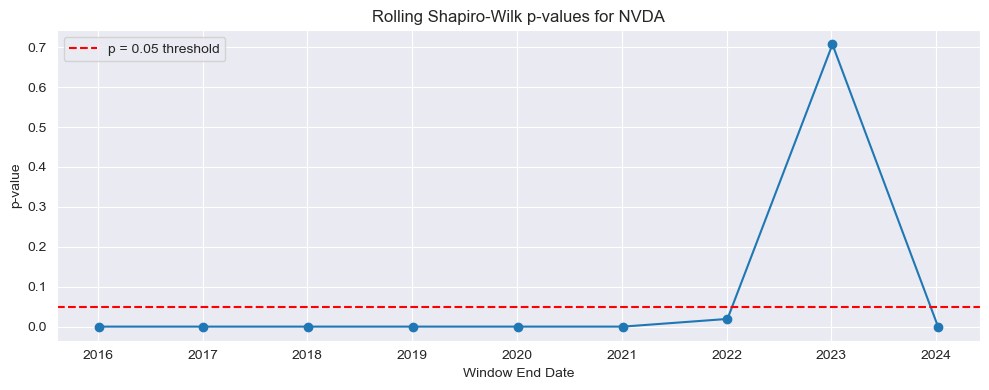

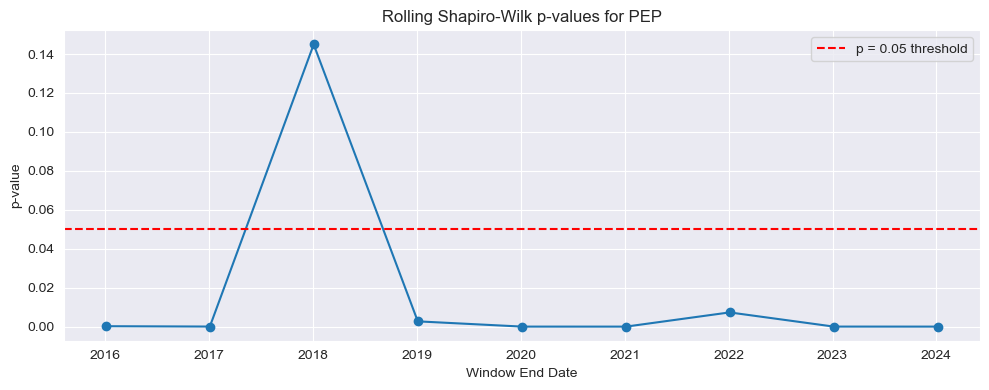

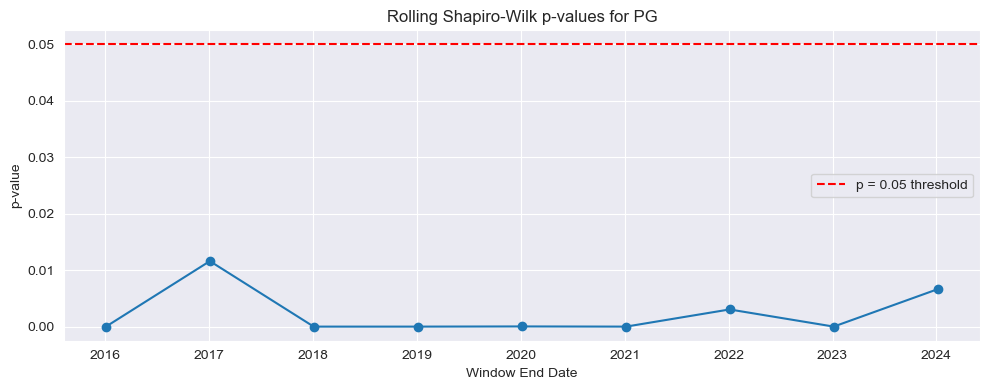

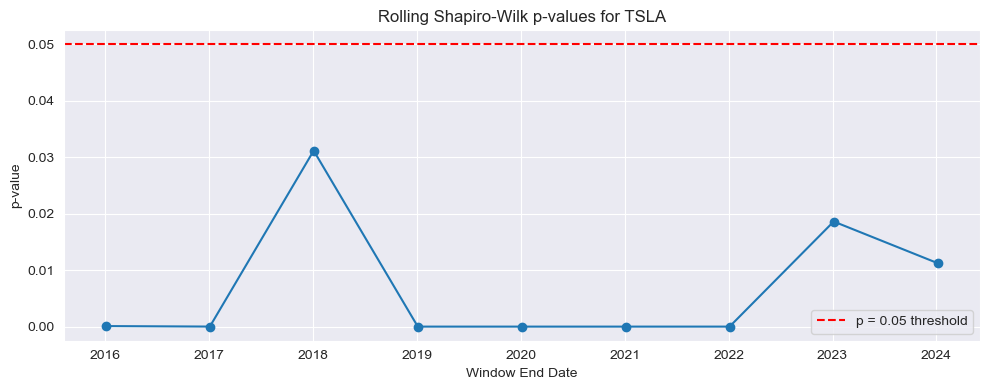

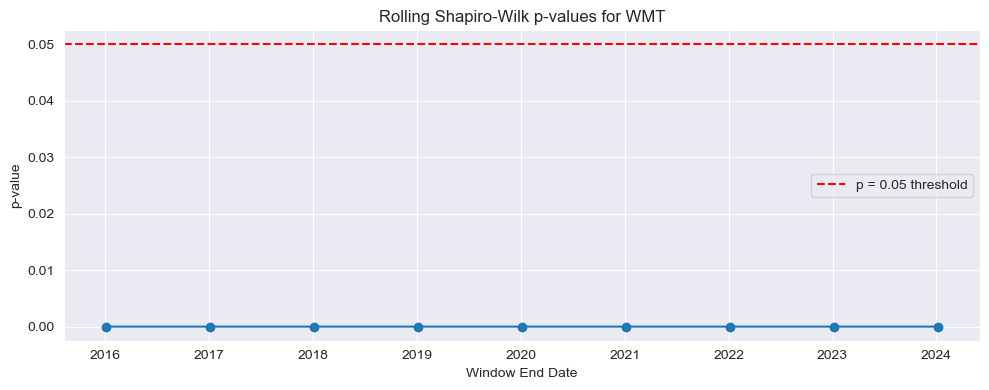

In [131]:
for ticker, windows in rolling_results.items():
    dates = [end for _, end, _ in windows]
    pvals = [p for _, _, p in windows]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, pvals, marker='o')
    plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05 threshold')
    plt.title(f"Rolling Shapiro-Wilk p-values for {ticker}")
    plt.ylabel('p-value')
    plt.xlabel('Window End Date')
    plt.legend()
    plt.tight_layout()
    plt.show()


**OBSERVATIONS**

- Most stocks show strong evidence against normality for most time windows (p < 0.05).
- Only a few specific 1-year windows per stock have p-values suggesting log returns may be normally distributed.

For stocks:

1. AAPL:
- Shows two periods (2021–2023) with borderline to moderate p-values (0.15, 0.06).
- Normality might be plausible in these windows, but not consistently.
2. D:
- Only one window (2021–2022) has a mild p-value (0.0712), weak evidence for normality.
3. JNJ:
- No time window passes the normality threshold.
- Strong and consistent deviation from normal returns.
4. JPM:
- Two consecutive windows (2021–2023) show strong evidence of normality, with p = 0.7677 and 0.1432.
- Suggests a relatively stable return behavior over that period.
5. KO:
- Evidence of normality in both early (2015–2016) and recent (2024–2025) windows.
- Might suggest a mean-reverting or stable return structure across time.
6. NVDA:
- One recent window (2022–2023) shows strong normality evidence (p = 0.7070).
- Otherwise likely driven by volatility and outliers.
7. PEP:
- A single window (2017–2018) shows modest evidence (p = 0.1450).
- May have undergone regime shifts or volatility clustering.
8. PG, TSLA, WMT:
- No windows with p > 0.05.
- Suggests persistent non-normal behavior, possibly due to structural trends or volatility shocks.

**$\therefore$ Normality of log returns is time-dependent and rarely holds over long durations.**

### Objective 2:
To test if removing extremal return data creates a distribution with evidence of being normal.

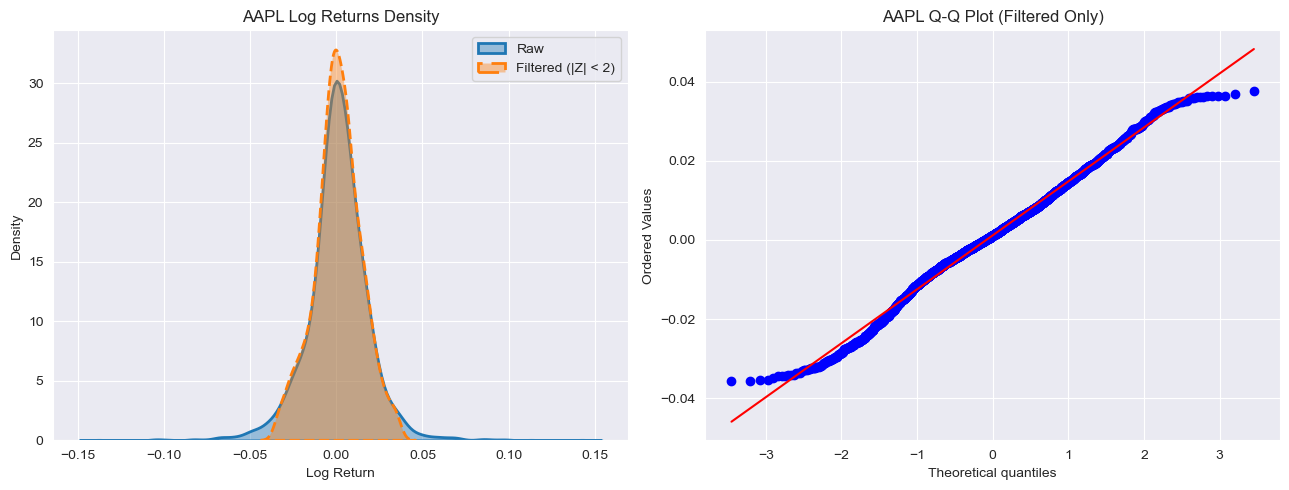

AAPL Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.1571 → Possibly normal
------------------------------------------------------------


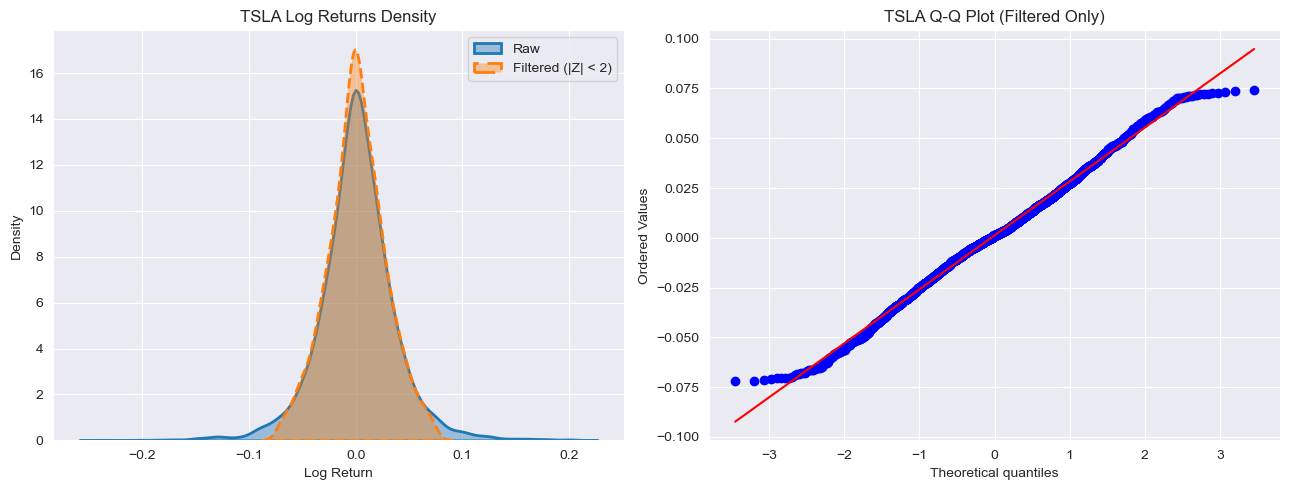

TSLA Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.8910 → Possibly normal
------------------------------------------------------------


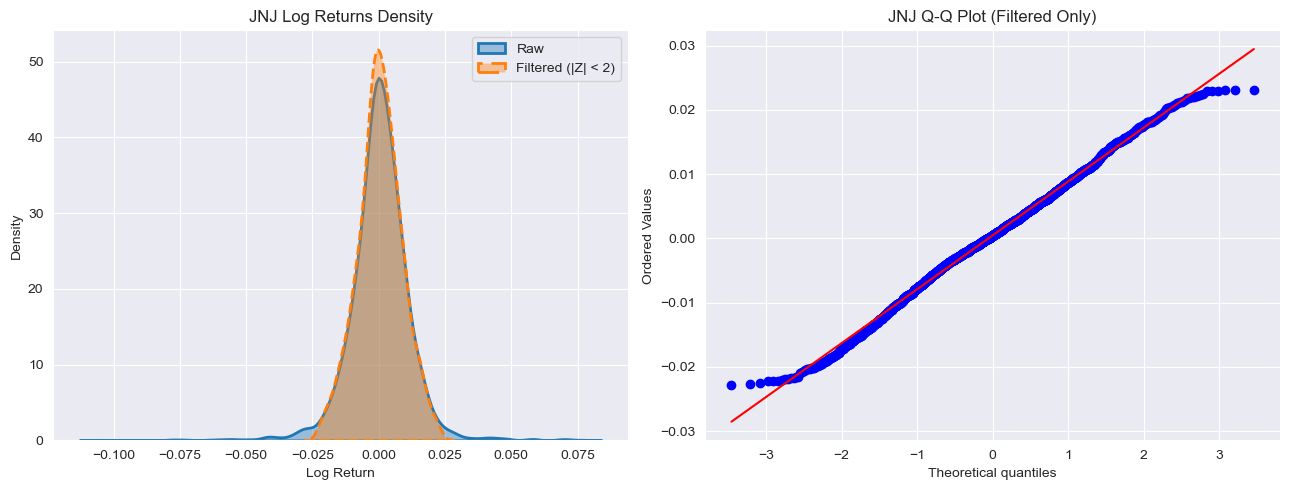

JNJ Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.5113 → Possibly normal
------------------------------------------------------------


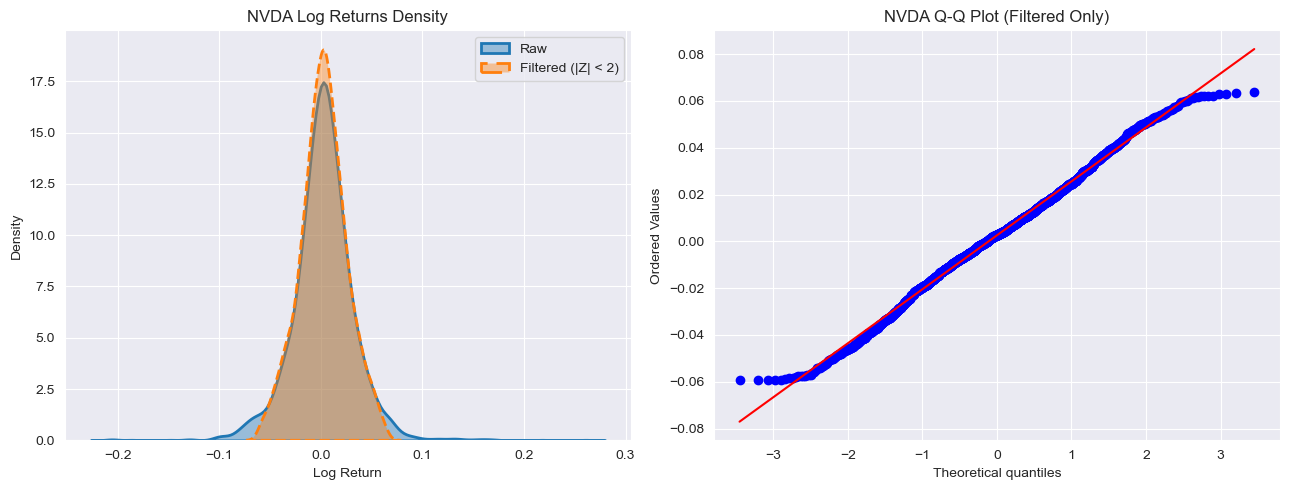

NVDA Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.8089 → Possibly normal
------------------------------------------------------------


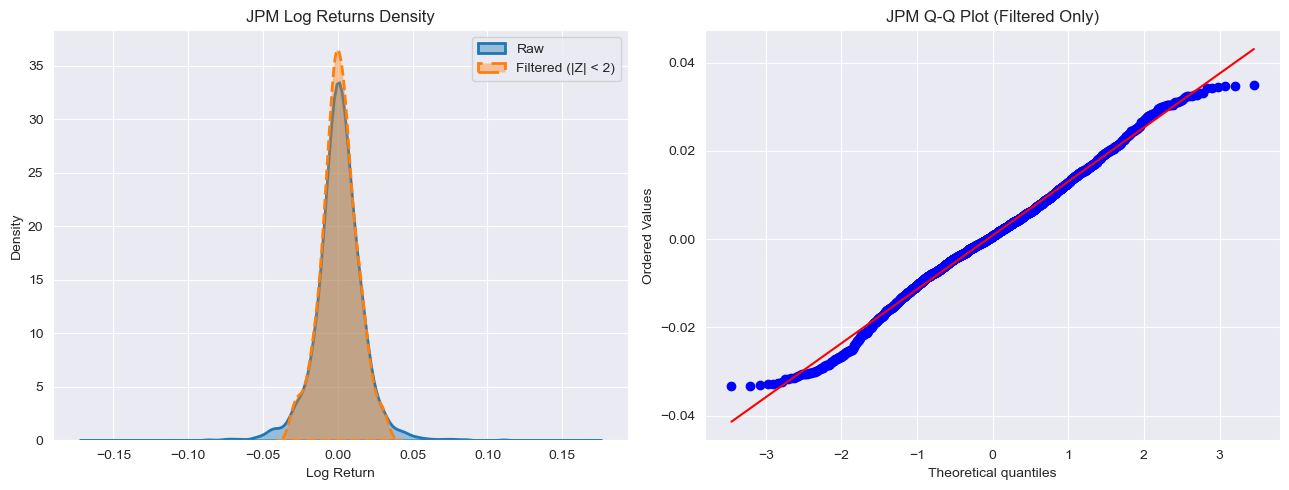

JPM Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.1066 → Possibly normal
------------------------------------------------------------


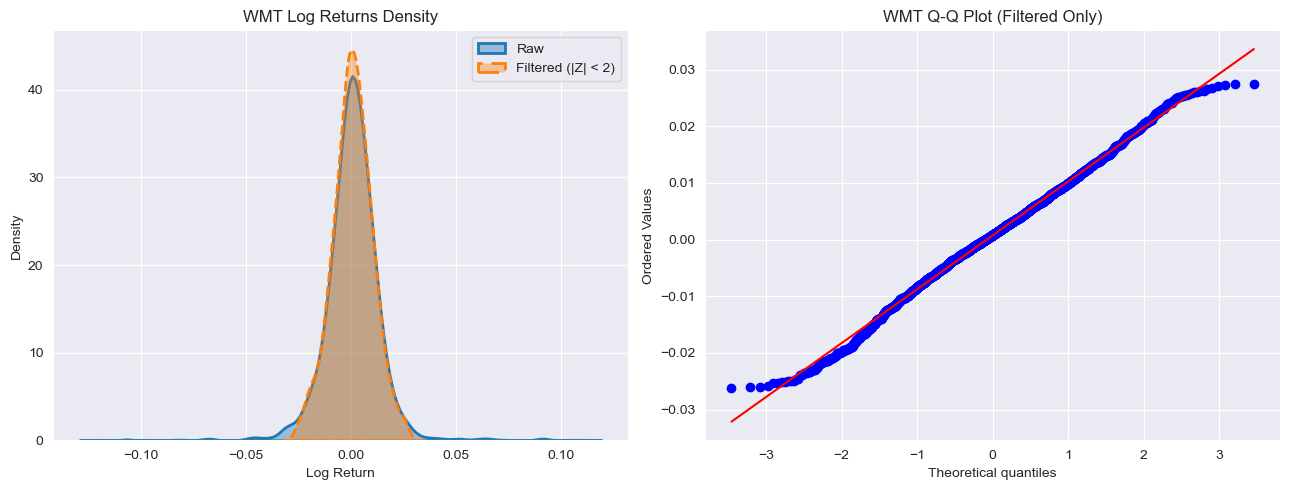

WMT Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.2443 → Possibly normal
------------------------------------------------------------


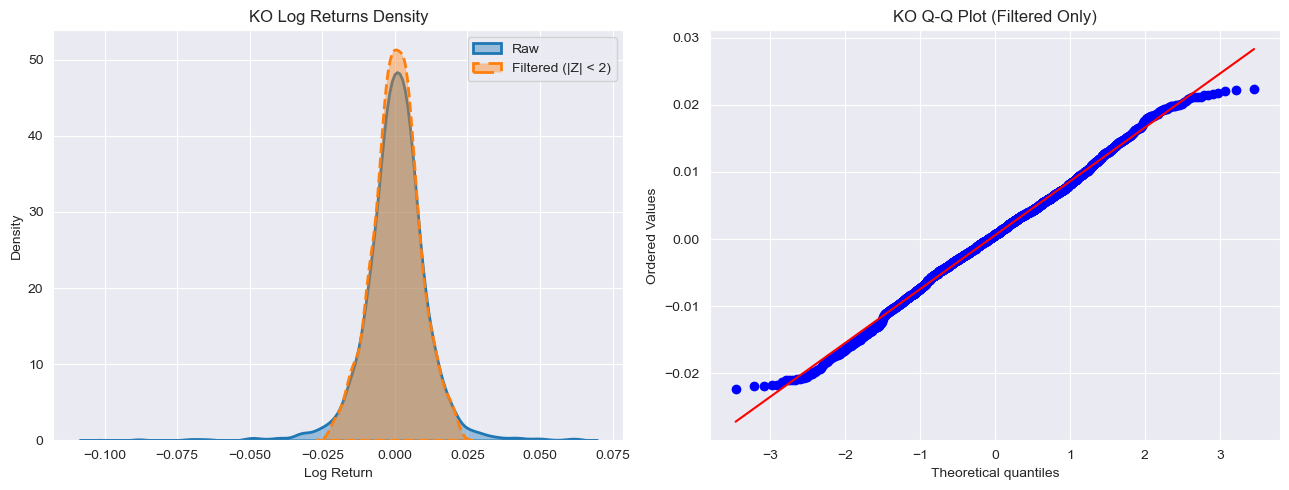

KO Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.4684 → Possibly normal
------------------------------------------------------------


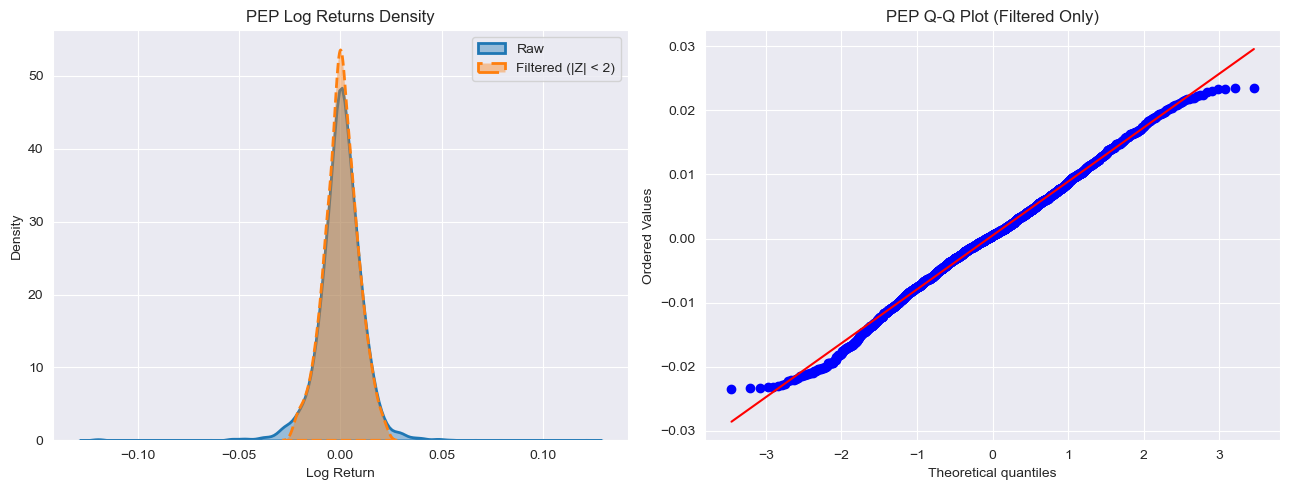

PEP Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.1404 → Possibly normal
------------------------------------------------------------


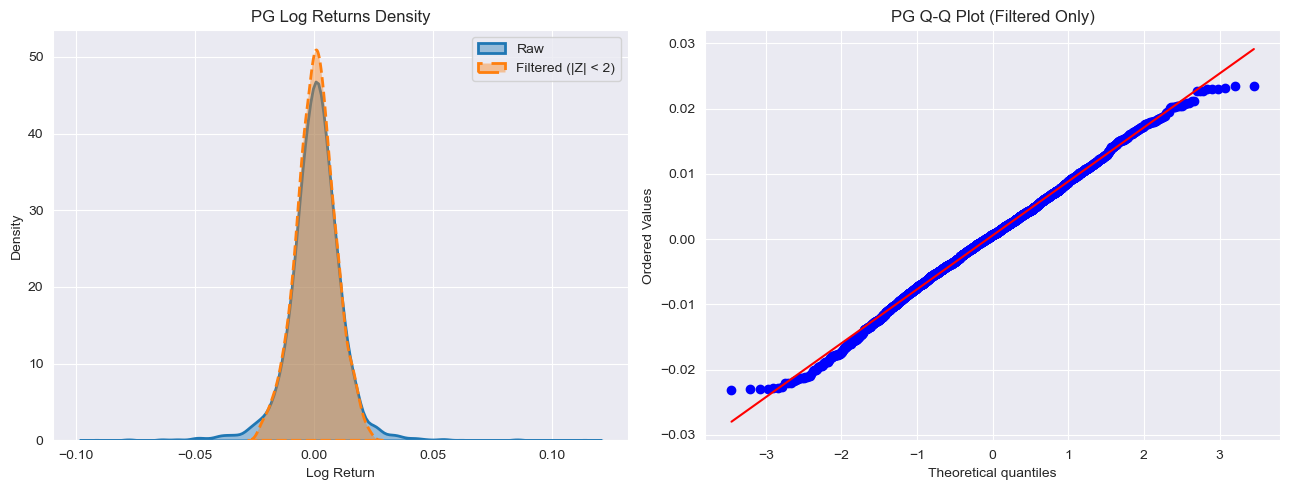

PG Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.2472 → Possibly normal
------------------------------------------------------------


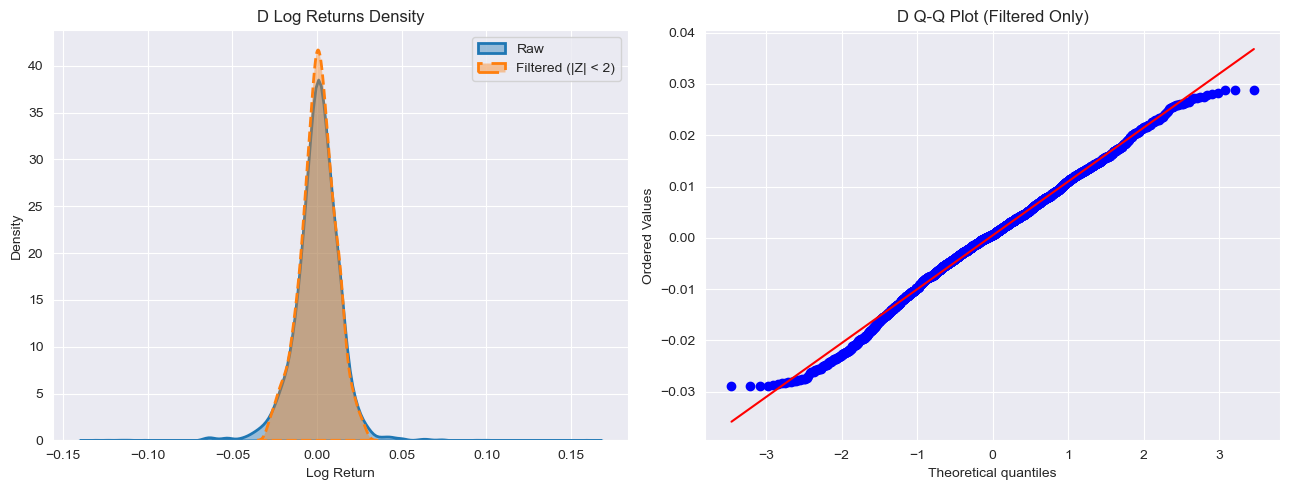

D Normality Test Results (D’Agostino & Pearson):
  Raw Data:      p = 0.0000 → NOT normal
  Filtered Data: p = 0.0011 → NOT normal
------------------------------------------------------------


In [127]:
z_thresh = 2

for ticker in tickers:
    raw = log_returns[ticker].dropna()
    filtered = remove_extremes(raw, z_thresh)

    p_raw = stats.normaltest(raw)[1]
    p_filt = stats.normaltest(filtered)[1]

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Overlaid density plot with fill
    sns.kdeplot(raw, ax=axes[0], label='Raw', fill=True, alpha=0.4, linewidth=2)
    sns.kdeplot(filtered, ax=axes[0], label=f'Filtered (|Z| < {z_thresh})', fill=True, alpha=0.4, linestyle='--', linewidth=2)
    axes[0].set_title(f'{ticker} Log Returns Density')
    axes[0].set_xlabel('Log Return')
    axes[0].legend()

    # Q-Q plot of filtered
    stats.probplot(filtered, dist="norm", plot=axes[1])
    axes[1].set_title(f'{ticker} Q-Q Plot (Filtered Only)')

    plt.tight_layout()
    plt.show()

    print(f"{ticker} Normality Test Results (D’Agostino & Pearson):")
    print(f"  Raw Data:      p = {p_raw:.4f} → {'NOT normal' if p_raw < 0.05 else 'Possibly normal'}")
    print(f"  Filtered Data: p = {p_filt:.4f} → {'NOT normal' if p_filt < 0.05 else 'Possibly normal'}")
    print('-' * 60)


**Observations**

- After the removal of outliers, the log returns become more normally distibuted.

### Objective 3:
- To create a personalized portfolio of stocks with historical log return data that is normally distributed.

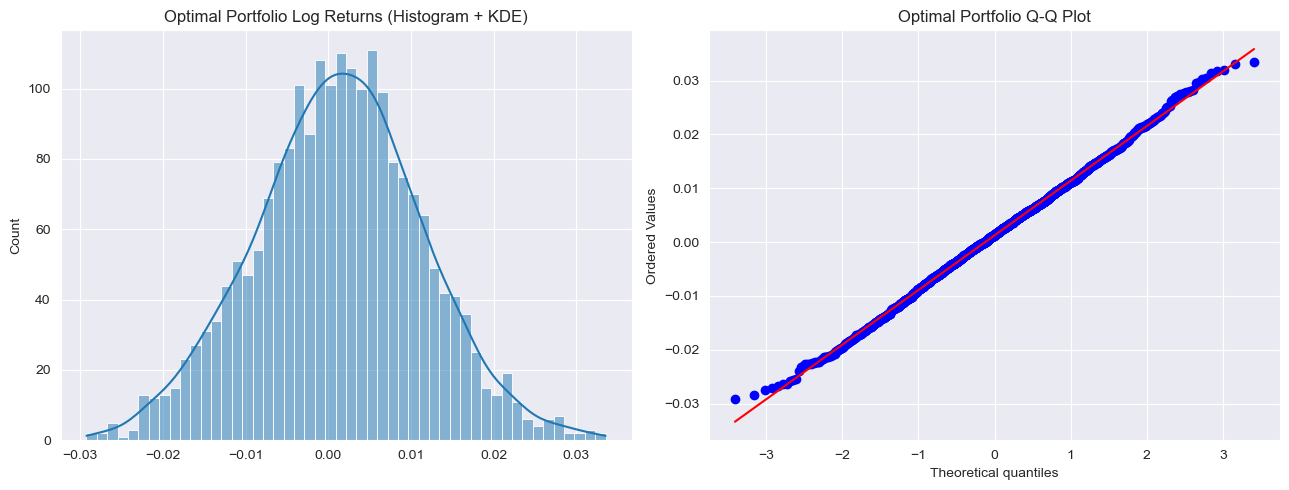

📊 Optimal Portfolio Weights (Filtered Returns):
  JNJ: 0.00
  TSLA: 0.30
  NVDA: 0.10
  KO: 0.50
  WMT: 0.10

🧾 Portfolio Normality Test (D’Agostino & Pearson):
  p-value = 0.9795 → Possibly Normal


In [141]:
import itertools

def generate_weight_combinations(n_assets, step=0.05):
    """
    Generate all weight combinations (step size) that sum to 1.
    Returns a list of tuples.
    """
    grid = np.arange(0, 1 + step, step)
    combos = [
        combo for combo in itertools.product(grid, repeat=n_assets)
        if np.isclose(sum(combo), 1.0, atol=1e-4)
    ]
    return combos

# Define tickers for the portfolio, selected the ones that had max p-value after filtering in (2)
portfolio_tickers = ['JNJ', 'TSLA', 'NVDA', 'KO', 'WMT']
z_thresh = 2.0

# Filtered log returns
filtered_log_returns_dict = {}
for ticker in portfolio_tickers:
    raw_series = log_returns[ticker].dropna()
    filtered_series = remove_extremes(raw_series, z_thresh)
    filtered_log_returns_dict[ticker] = filtered_series

filtered_log_returns = pd.DataFrame(filtered_log_returns_dict).dropna()

# Generate weight combinations
weight_grid = generate_weight_combinations(len(portfolio_tickers), step=0.1)

# Grid search to maximize normality p-value
best_p = -1
best_weights = None

for weights in weight_grid:
    weighted_returns = filtered_log_returns.mul(weights, axis=1).sum(axis=1)
    if len(weighted_returns) < 8:
        continue
    p_val = stats.normaltest(weighted_returns)[1]
    if p_val > best_p:
        best_p = p_val
        best_weights = weights

# Final results
best_weights_arr = np.array(best_weights)
portfolio_filtered_best = filtered_log_returns.mul(best_weights_arr, axis=1).sum(axis=1)
conclusion = "Possibly Normal" if best_p > 0.05 else "Not Normal"

# Step 5: Visualization
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.histplot(portfolio_filtered_best, kde=True, bins=50, ax=axs[0])
axs[0].set_title("Optimal Portfolio Log Returns (Histogram + KDE)")
stats.probplot(portfolio_filtered_best, dist="norm", plot=axs[1])
axs[1].set_title("Optimal Portfolio Q-Q Plot")

plt.tight_layout()
plt.show()

# Print results
print("📊 Optimal Portfolio Weights (Filtered Returns):")
for t, w in zip(portfolio_tickers, best_weights_arr):
    print(f"  {t}: {w:.2f}")
print(f"\n🧾 Portfolio Normality Test (D’Agostino & Pearson):")
print(f"  p-value = {best_p:.4f} → {conclusion}")


### Objective 4
- Test if the portfolio I created in the first mini-project has significant periods of time with evidence of normally distributed log returns.

In [150]:
import pandas as pd

stocks = pd.read_csv("prices.csv", index_col=0, parse_dates=True)
log_returns4 = compute_log_returns(stocks)

In [151]:
def compute_portfolio_returns(log_returns_df, tickers, weights):
    aligned = log_returns_df[tickers].dropna()
    weighted = aligned.mul(weights, axis=1)
    return weighted.sum(axis=1)

In [154]:
hr_weights = pd.read_csv("high_risk_portfolio_weights.csv").rename(columns={"Unnamed: 0": "Ticker"})
tickersh = hr_weights["Ticker"].tolist()
weightsh = hr_weights["Weight"].values

portfolio_returnsh = compute_portfolio_returns(log_returns4, tickersh, weightsh)

lr_weights = pd.read_csv("low_risk_portfolio_weights.csv").rename(columns={"Unnamed: 0": "Ticker"})
tickersw = lr_weights["Ticker"].tolist()
weightsw = lr_weights["Weight"].values

portfolio_returnsw = compute_portfolio_returns(log_returns4, tickersw, weightsw)


In [155]:
def rolling_shapiro(series, window=252):
    results = []
    for start in range(0, len(series) - window + 1, window):
        window_series = series.iloc[start:start+window]
        if len(window_series) < 3:
            continue
        stat, p = stats.shapiro(window_series)
        results.append((window_series.index[0], window_series.index[-1], p))
    return results


In [156]:
rolling_resultsh = rolling_shapiro(portfolio_returnsh, window=252)
rolling_resultsw = rolling_shapiro(portfolio_returnsw, window=252)

In [158]:
for start, end, p in rolling_resultsh:
    if p > 0.05:
        print(f"For the high-risk portfolio: {start.date()} to {end.date()} → p = {p:.4f}")


For the high-risk portfolio: 2022-01-05 to 2023-01-05 → p = 0.7440


In [159]:
for start, end, p in rolling_resultsw:
    if p > 0.05:
        print(f"For the low-risk portfolio: {start.date()} to {end.date()} → p = {p:.4f}")


For the low-risk portfolio: 2023-01-06 to 2024-01-08 → p = 0.6654


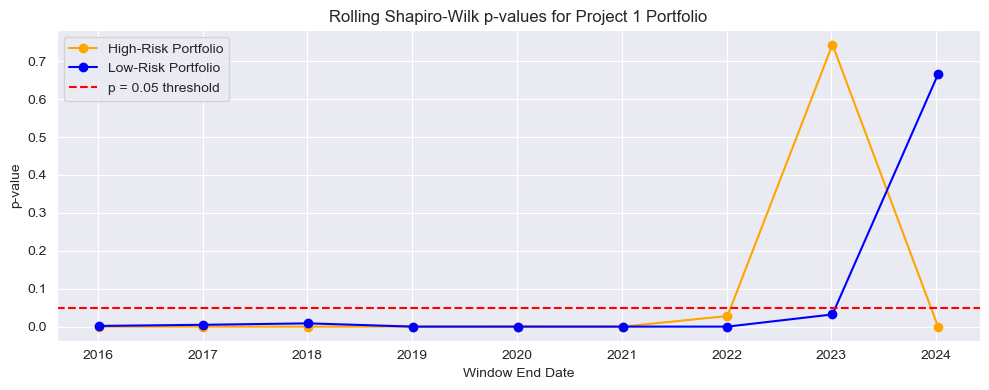

In [163]:
datesh = [end for _, end, _ in rolling_resultsh]
pvalsh = [p for _, _, p in rolling_resultsh]

datesw = [end for _, end, _ in rolling_resultsw]
pvalsw = [p for _, _, p in rolling_resultsw]

plt.figure(figsize=(10, 4))
plt.plot(datesh, pvalsh, marker='o', color='orange', label='High-Risk Portfolio')
plt.plot(datesw, pvalsw, marker='o', color='blue', label='Low-Risk Portfolio')
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05 threshold')
plt.title("Rolling Shapiro-Wilk p-values for Project 1 Portfolio")
plt.ylabel("p-value")
plt.xlabel("Window End Date")
plt.legend()
plt.tight_layout()
plt.show()


**Observations**

- In the 2022–2023 window, the high-risk portfolio crosses the 0.05 threshold (p ≈ 0.74) → indicating possible normality.
- In the 2023–2024 window, the low-risk portfolio shows a clear normality window (p ≈ 0.67), while the high-risk portfolio returns to being non-normal.

### Objective 5
- To gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

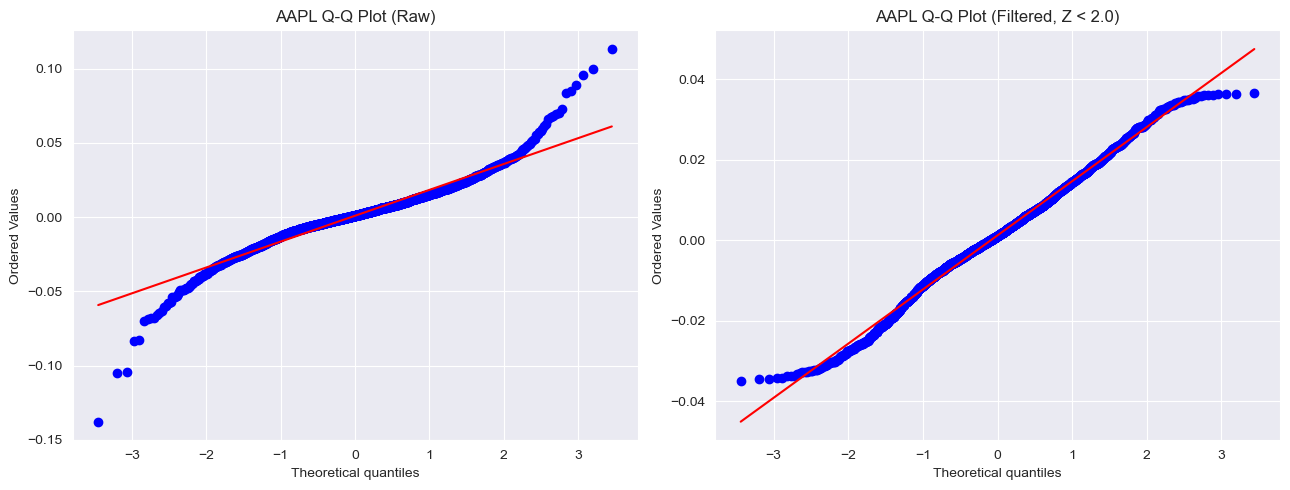

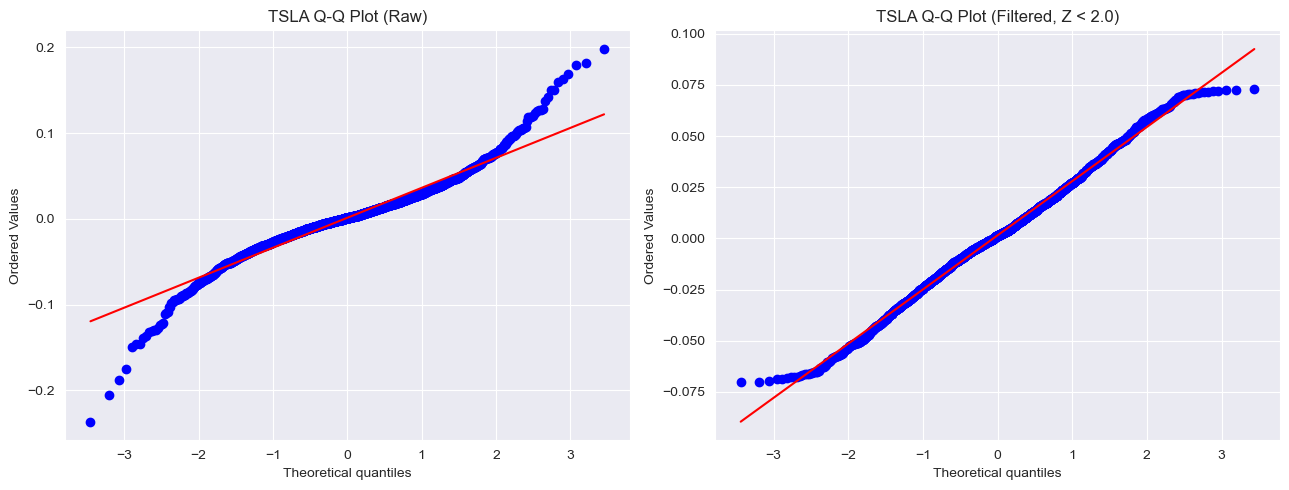

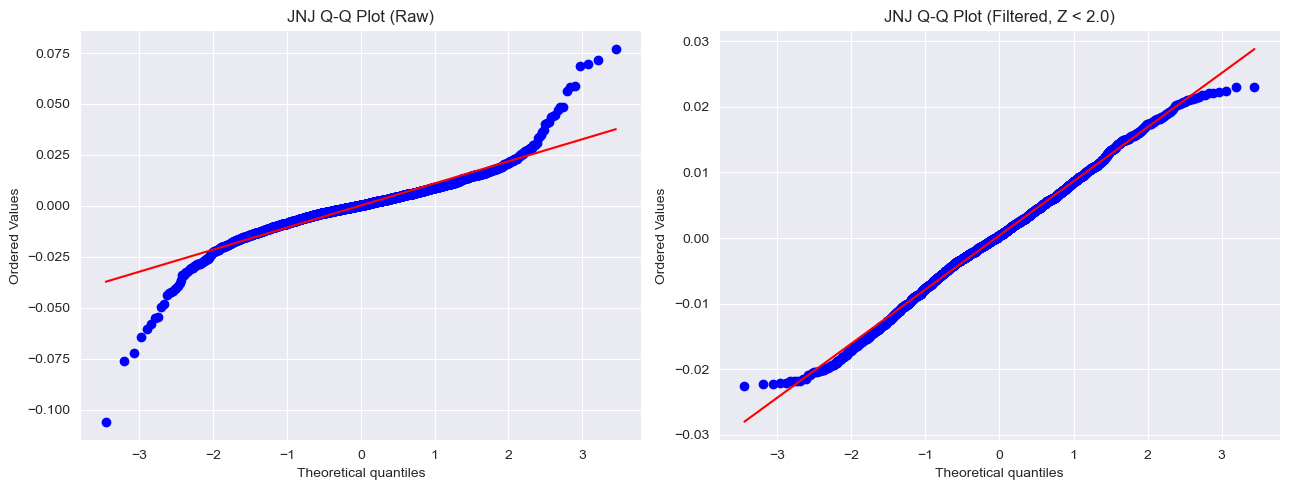

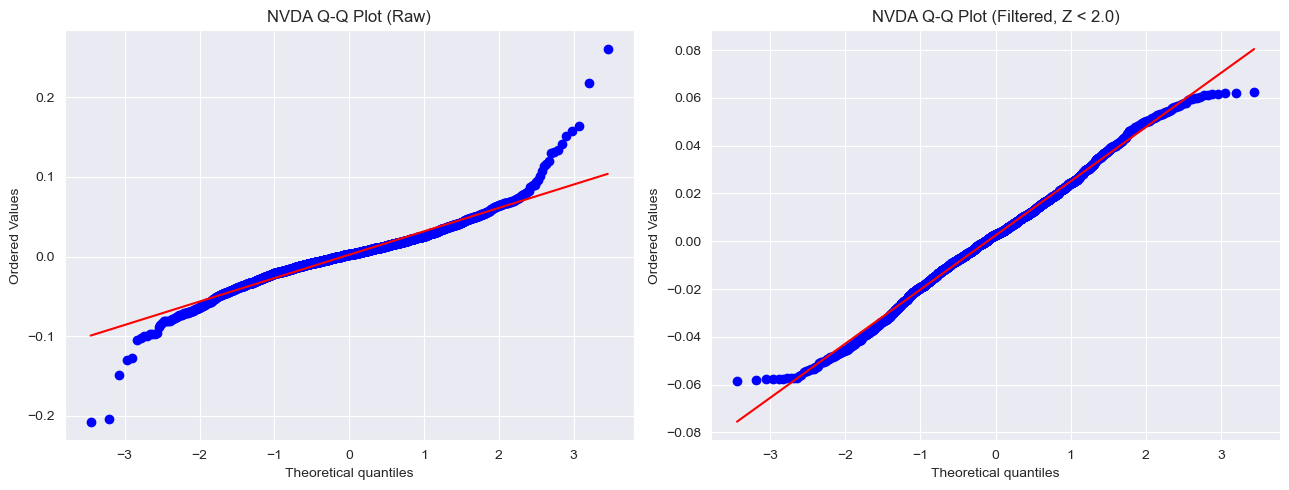

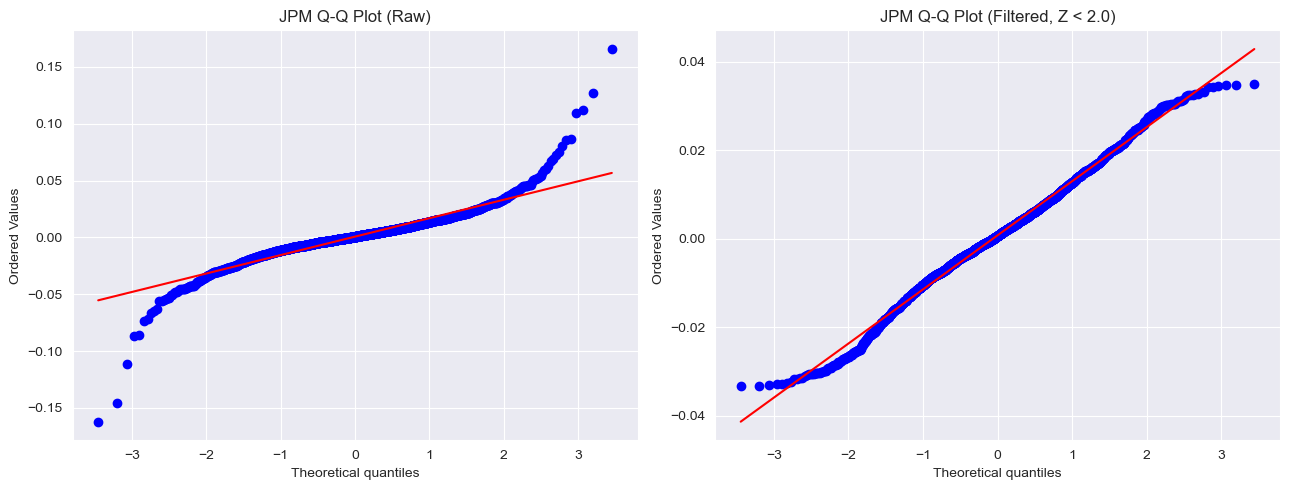

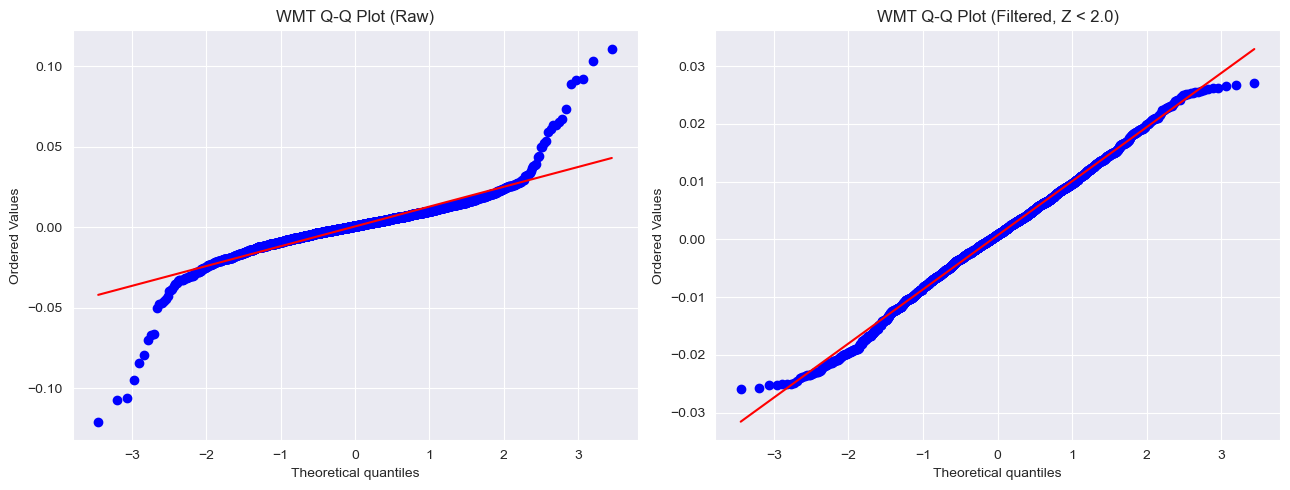

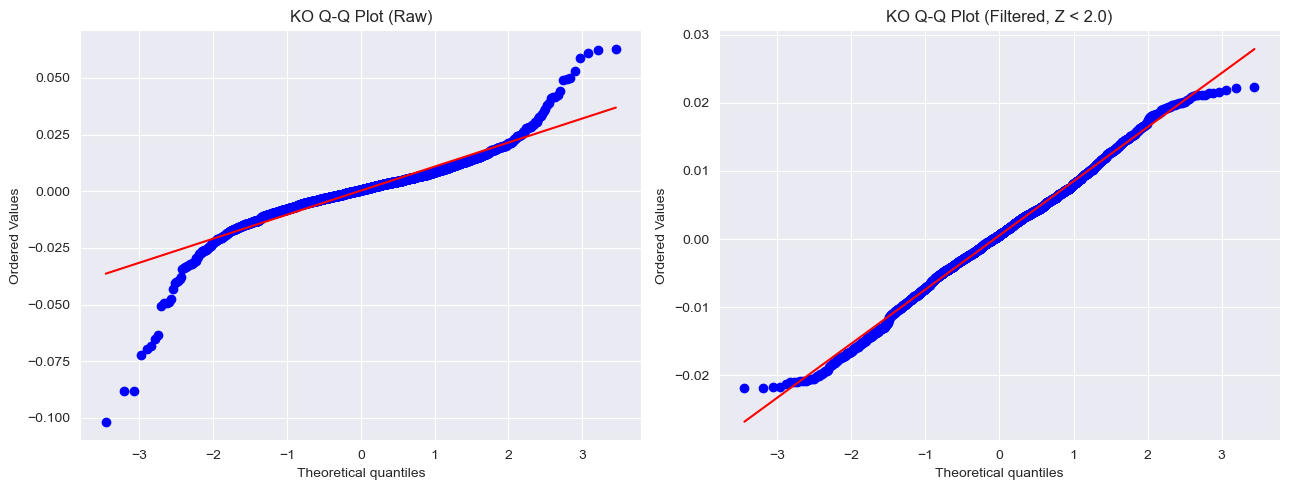

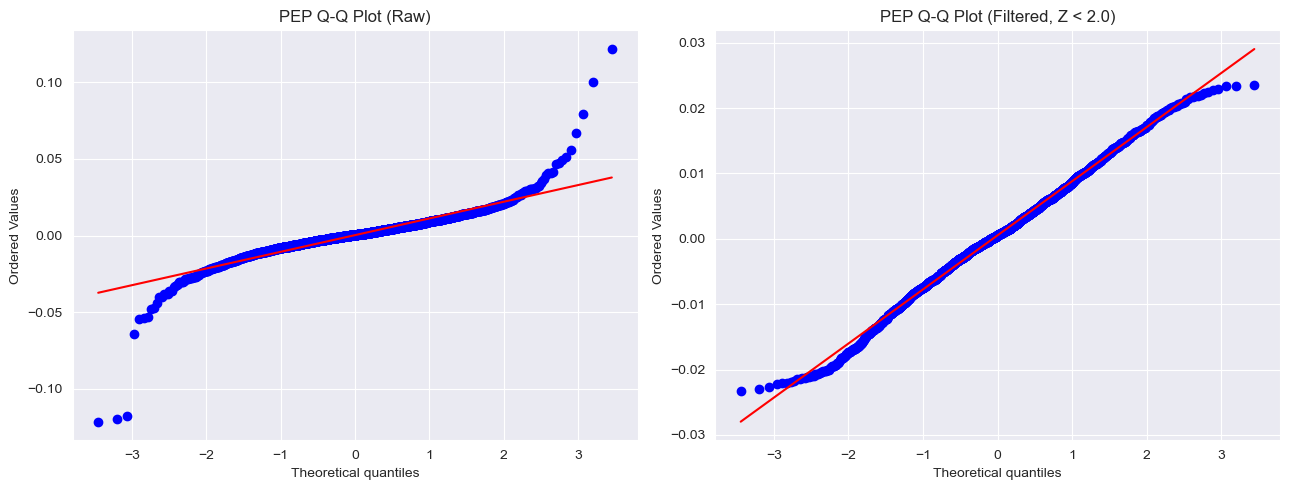

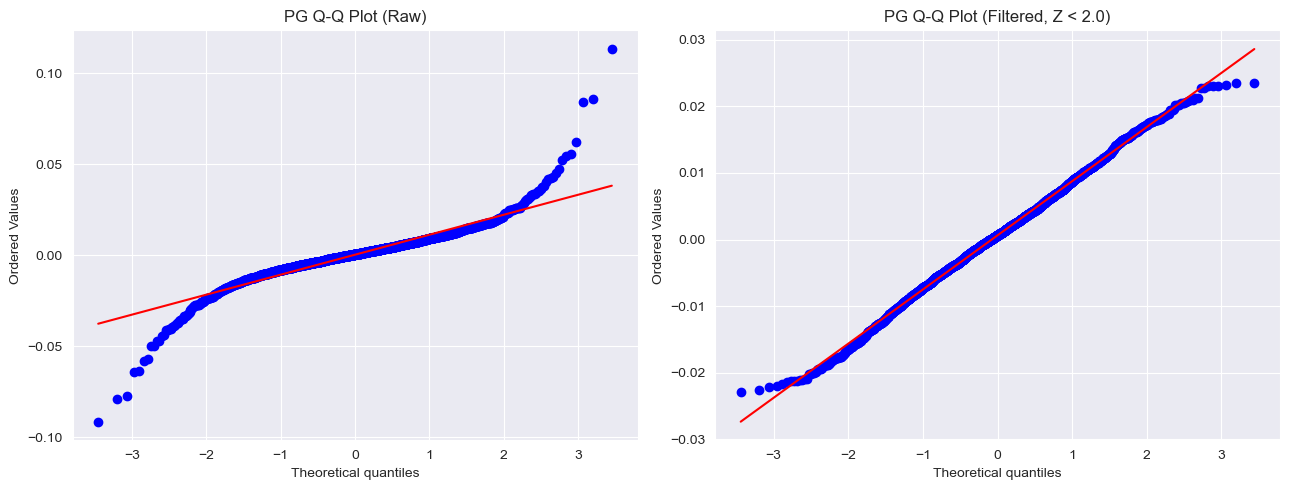

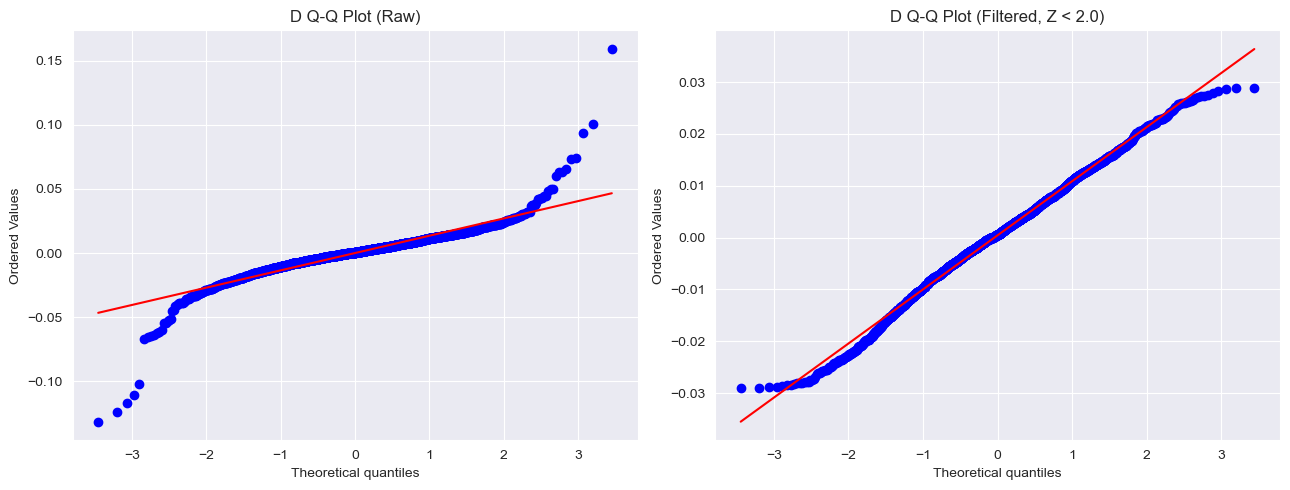

,Ticker,p (DAG),p (Shapiro),p (Filtered),Raw Conclusion,Filtered Conclusion
0,AAPL,0.0,0.0,0.3861,Not Normal,Possibly Normal
1,TSLA,0.0,0.0,0.7795,Not Normal,Possibly Normal
2,JNJ,0.0,0.0,0.4167,Not Normal,Possibly Normal
3,NVDA,0.0,0.0,0.8809,Not Normal,Possibly Normal
4,JPM,0.0,0.0,0.0884,Not Normal,Possibly Normal
5,WMT,0.0,0.0,0.2095,Not Normal,Possibly Normal
6,KO,0.0,0.0,0.2778,Not Normal,Possibly Normal
7,PEP,0.0,0.0,0.2149,Not Normal,Possibly Normal
8,PG,0.0,0.0,0.7392,Not Normal,Possibly Normal
9,D,0.0,0.0,0.0022,Not Normal,Not Normal


In [149]:
results = []

for ticker in tickers:
    series = log_returns[ticker].dropna()
    filtered = remove_extremes(series, z_thresh)

    # Run both tests
    p_dag = stats.normaltest(series)[1]
    p_shapiro = stats.shapiro(series)[1]
    p_filtered = stats.normaltest(filtered)[1]

    results.append({
        'Ticker': ticker,
        'p (DAG)': round(p_dag, 4),
        'p (Shapiro)': round(p_shapiro, 4),
        'p (Filtered)': round(p_filtered, 4),
        'Raw Conclusion': 'Possibly Normal' if p_dag > 0.05 else 'Not Normal',
        'Filtered Conclusion': 'Possibly Normal' if p_filtered > 0.05 else 'Not Normal'
    })

    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    stats.probplot(series, dist="norm", plot=axs[0])
    axs[0].set_title(f'{ticker} Q-Q Plot (Raw)')

    stats.probplot(filtered, dist="norm", plot=axs[1])
    axs[1].set_title(f'{ticker} Q-Q Plot (Filtered, Z < {z_thresh})')

    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame(results)
summary_df

**Observations**

- Raw log returns (left) show heavy tails and deviations from the red line at both extremes --> indicate non-normality.
- After outlier-removal (filtered, right), the points align much more closely with the red line, especially in the center.
- So, filtering improves normality, but slight deviation at the tails remains. The distribution is closer to normal, but not perfect.